### Housekeeping

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import datetime as dt
from tensorflow import keras
from Settings import columns, experiments
import Pipeline
import matplotlib.pyplot as plt
import keras_tuner as kt

%matplotlib notebook
%load_ext tensorboard

In [2]:
current_exp = experiments['all']

pipeline = Pipeline.DataClean(columns, current_exp)
pipeline.clean_data()
pipeline.norm()
pipeline.split_label()
pipeline.train_val()  

i made it to train val
imade it to else statement


Look into just using environmental variable instead of using the previous persistence of solar IR

In [3]:
pipeline.floatcols

Index(['Global CMP22 (vent/cor) [W/m^2]', 'Tower Wet Bulb Temp [deg C]',
       'Direct sNIP [W/m^2]', 'Azimuth Angle [degrees]',
       'Tower Dew Point Temp [deg C]', 'Tower RH [%]', 'Total Cloud Cover [%]',
       'Peak Wind Speed @ 6ft [m/s]', 'Avg Wind Direction @ 6ft [deg from N]',
       'Station Pressure [mBar]', 'Precipitation (Accumulated) [mm]',
       'Snow Depth [cm]', 'Moisture', 'Albedo (CMP11)'],
      dtype='object')

# Model Creation

#### Model Hyperparameters

In [4]:
# setting seed
SEED = 26
# try:
#     tf.random.set_seed(SEED)
# except:
#     tf.set_random_seed(SEED)

### Skeleton
Below is creating the "skeleton" of the model. It does not need any specific data, only the shape and what it will do

Using the functional API method

In [5]:
def create_model(pipeline, exp):
    # First we start with an input layer
    input_layer = keras.layers.Input(shape=(pipeline.xtrain[0].shape)) # size per sample, equal to number of features

    # Dropout may be useful for hidden layers if the number of hidden nodes is large
    # Let's apply dropout to the input layer. (If Dropout(0), Dropout isn't being used)
    layers = keras.layers.Dropout(exp['DROPOUT'])(input_layer)
    
    ACTIVATION = [exp['ACTIVATION']]*len(exp['HIDDENS'])
    
    for hidden,activation in zip(exp['HIDDENS'], ACTIVATION):
        layers = keras.layers.Dense(hidden, activation=activation,
                       bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                       kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)

        layers = keras.layers.Dropout(exp['DROPOUT'])(layers)

    # Output layer has a softmax function to convert output to class likelihood
    output_layer = keras.layers.Dense(pipeline.ytrain[0].shape[0], activation='softmax',
                      bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
                      kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED))(layers)


    model= keras.Model(input_layer, output_layer)
    
    return model

In [6]:
model = create_model(pipeline, current_exp)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1680)]            0         
                                                                 
 dropout (Dropout)           (None, 1680)              0         
                                                                 
 dense (Dense)               (None, 90)                151290    
                                                                 
 dropout_1 (Dropout)         (None, 90)                0         
                                                                 
 dense_1 (Dense)             (None, 8)                 728       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 16)                144   

### Compile and Train the model

In [7]:
model.compile(optimizer=current_exp['optimizer'],
             loss=keras.losses.MeanSquaredError(),
             metrics=current_exp['metrics'])

log_dir = "logs/fit/" + dt.datetime.now().strftime("%Y%m%d-%H%M%S")
# callbacks ensures logs are created and stored
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1) 

history = model.fit(x=pipeline.xtrain, 
          y=pipeline.ytrain, 
          epochs=5, 
          validation_data=(pipeline.xval, pipeline.yval), 
          callbacks=[tensorboard_callback, current_exp['EARLY_STOPPING']])

Epoch 1/5
6723/6723 [==============================] - 44s 6ms/step - loss: 232683.7812 - accuracy: 0.5112 - val_loss: 112934.2266 - val_accuracy: 0.6833
Epoch 2/5
6723/6723 [==============================] - 44s 7ms/step - loss: 232684.5000 - accuracy: 0.5201 - val_loss: 112934.1875 - val_accuracy: 0.7129
Epoch 3/5
6723/6723 [==============================] - 48s 7ms/step - loss: 232685.0469 - accuracy: 0.5231 - val_loss: 112934.1719 - val_accuracy: 0.6971
Epoch 4/5
6723/6723 [==============================] - 46s 7ms/step - loss: 232684.5156 - accuracy: 0.5195 - val_loss: 112934.2109 - val_accuracy: 0.6984
Epoch 5/5
6723/6723 [==============================] - 48s 7ms/step - loss: 232684.7500 - accuracy: 0.5213 - val_loss: 112934.1953 - val_accuracy: 0.6955


<IPython.core.display.Javascript object>


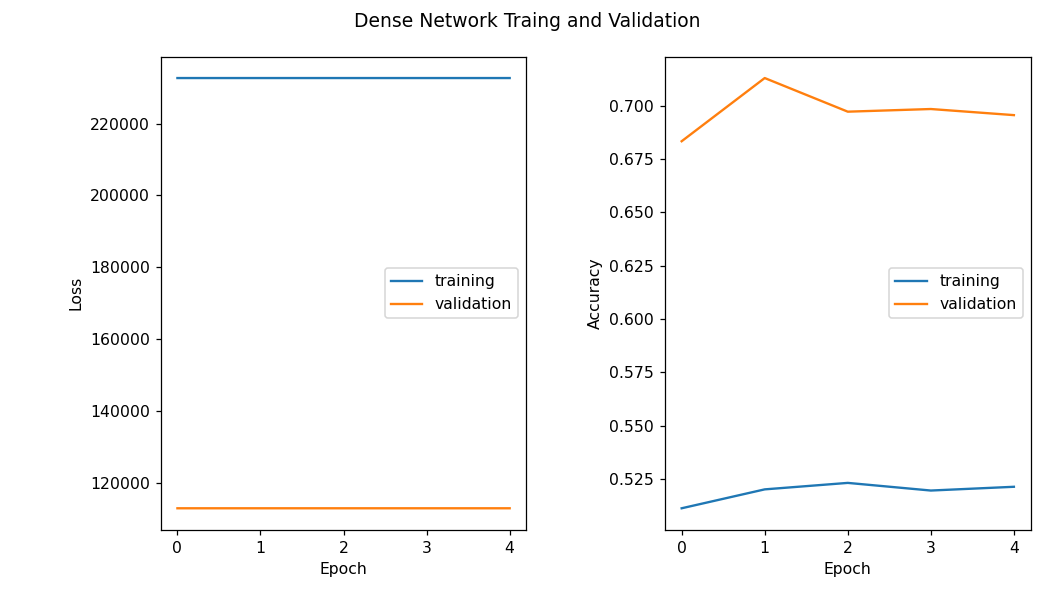

In [20]:
# Let's plot the change in loss and accuracy
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'], label='training')
axs[0].plot(history.history['val_loss'], label='validation')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(history.history['accuracy'], label='training')
axs[1].plot(history.history['val_accuracy'], label='validation')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
fig.suptitle('Dense Network Traing and Validation')
plt.tight_layout()

### Tensorboard

In [9]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 13284), started 9:10:59 ago. (Use '!kill 13284' to kill it.)

## Predicting the Validation data

In [10]:
predict = model.predict(pipeline.xval)

<IPython.core.display.Javascript object>


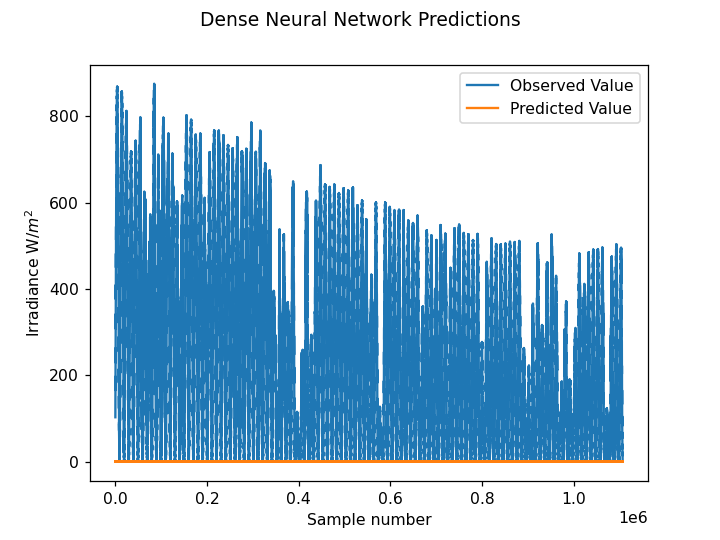

Text(0.5, 0, 'Sample number')

In [11]:
pfig, pax = plt.subplots()
pax.plot(pipeline.yval.reshape(-1), label='Observed Value')
pax.plot(predict.reshape(-1), label='Predicted Value')
pfig.suptitle('Dense Neural Network Predictions')
pax.legend()
pax.set_ylabel('Irradiance W/$m^2$')
pax.set_xlabel('Sample number')

### Keras-Tuner

In [12]:
def reshape(data):
    return data.reshape(-1, 120, 14)

xtrain = reshape(pipeline.xtrain)
# reshape(pipeline.ytrain)
xval = reshape(pipeline.xval)
# reshape(pipeline.yval)

In [13]:
# def model_builder(hp):
#   model = keras.Sequential()
#   model.add(keras.layers.Flatten(input_shape=(120,14)))

#   # Tune the number of units in the first Dense layer
#   # Choose an optimal value between 32-512
#   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#   model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#   model.add(keras.layers.Dense(12))

#   # Tune the learning rate for the optimizer
#   # Choose an optimal value from 0.01, 0.001, or 0.0001
#   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.MeanSquaredError(),
#                 metrics=['accuracy'])

#   return model



def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.Flatten(input_shape=(120,14)))

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=240)
    model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
    hp_units1 = hp.Int('units', min_value=32, max_value=512, step=240)
    model.add(keras.layers.Dense(units=hp_units1, activation='relu'))
    model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
    hp_units2 = hp.Int('units', min_value=32, max_value=512, step=240)
    model.add(keras.layers.Dense(units=hp_units2, activation='relu'))
    model.add(keras.layers.Dropout(current_exp['DROPOUT']))
    
    model.add(keras.layers.Dense(12))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=['accuracy'])

    return model







# model.add(keras.layers.Dense(units=hp_units, activation='relu',
#                                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)))
#     model.add(keras.layers.Dropout(exp['DROPOUT']))
    
# #     hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#     model.add(keras.layers.Dense(units=hp_units, activation='relu',
#                                  bias_initializer=tf.keras.initializers.RandomNormal(seed=SEED),
#                                  kernel_initializer=tf.keras.initializers.RandomNormal(seed=SEED)))
#     model.add(keras.layers.Dropout(exp['DROPOUT']))

In [14]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt',
                     overwrite=True)

In [15]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=5)

In [16]:
tuner.search(xtrain, pipeline.ytrain, epochs=10, validation_data=(xval, pipeline.yval), callbacks=[stop_early])

Trial 2 Complete [00h 01m 18s]
val_accuracy: 0.04091283679008484

Best val_accuracy So Far: 0.27994707226753235
Total elapsed time: 00h 02m 32s

Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
272               |32                |units
0.0001            |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
4633/6723 [===================>..........] - ETA: 21s - loss: 19462.5117 - accuracy: 0.0899

KeyboardInterrupt: 

In [ ]:
tuner.search(xtrain, pipeline.ytrain, epochs=10, validation_data=(xval, pipeline.yval), callbacks=[stop_early])

In [ ]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
dir(tuner)
tuner.results_summary()

## Predicting the validation data